In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [165]:
data_path = "/home/rasteiger/datasets/hack4good/"
cache_file = data_path + 'time_series_features.csv'

In [166]:
df.columns

Index(['filename', 'date', 'farmer_id', 'site_id', 'lat', 'lon', 'crop_name',
       'growth_stage', 'damage', 'extent', 'season', 'is_damage',
       'ts_columns0', 'ts_columns1', 'ts_columns2', 'ts_columns3',
       'ts_columns4', 'ts_columns5', 'ts_columns6', 'ts_columns7',
       'ts_columns8', 'ts_columns9', 'ts_columns10', 'ts_columns11',
       'ts_columns12'],
      dtype='object')

In [183]:
df = pd.read_csv(cache_file)

In [184]:
#df['is_damage'] = df['damage']
#df = df[~df['is_damage'].isin(['WN', 'FD'])]

In [185]:
ts_columns = [c for c in df.columns if c.startswith('ts_columns')]
feature_df = df[ts_columns + ['is_damage', 'farmer_id']]

In [186]:
def split_dataframe_on_column(df, column, split_sizes, random_state=42):
    
    if sum(split_sizes) != 1 or len(split_sizes) != 3:
        raise ValueError("split sizes must sum up to 1.0 and have length == 3")

    feature_unique = pd.Series(df[column].unique())
    train_split, val_split, test_split = np.split(feature_unique.sample(frac=1, random_state=random_state), 
                                                  [int(split_sizes[0]*len(feature_unique)), int((split_sizes[0] + split_sizes[1])*len(feature_unique))])

    train_csv = df[df[column].isin(train_split)]
    val_csv = df[df[column].isin(val_split)]
    test_csv = df[df[column].isin(test_split)]

    return train_csv, val_csv, test_csv

In [187]:
df_train, df_val, df_test = [x.drop('farmer_id', axis=1) for x in split_dataframe_on_column(feature_df, 'farmer_id', [0.8, 0.1, 0.1])]

In [188]:
X_train = df_train.drop('is_damage', axis=1)
X_val = df_val.drop('is_damage', axis=1)
X_test = df_test.drop('is_damage', axis=1)

y_train = df_train['is_damage']
y_val = df_val['is_damage']
y_test = df_test['is_damage']

In [196]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight={0 : 0.1, 1 : 1.0})

In [197]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.1, 1: 1.0}, n_estimators=1000,
                       n_jobs=-1)

In [198]:
y_val_pred = rf.predict(X_val)

In [199]:
f1 = f1_score(y_val, y_val_pred, average='macro')
accuracy = balanced_accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro')
recall = recall_score(y_val, y_val_pred, average='macro')

In [200]:
f1, accuracy, precision, recall

(0.486027218619701, 0.5456693224641819, 0.5566230798720931, 0.5456693224641819)

<Axes: >

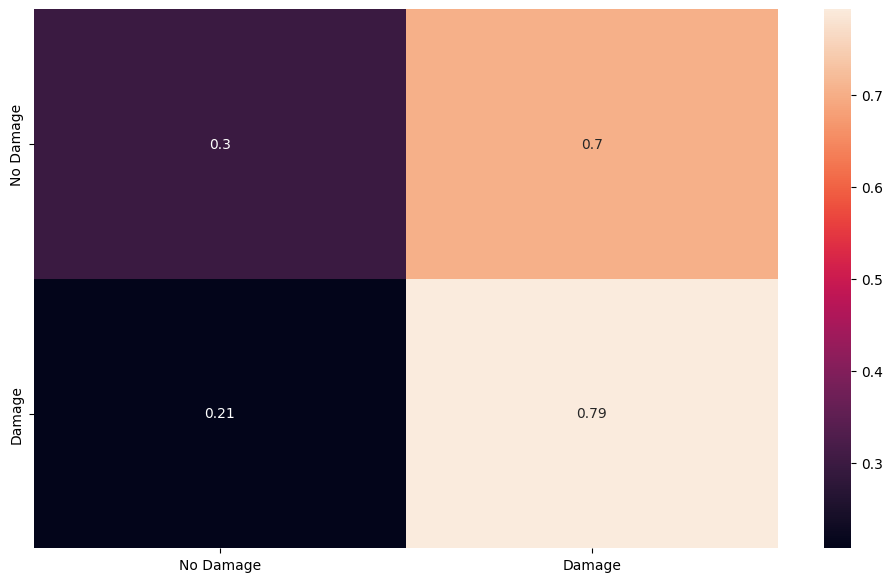

In [203]:
cf_matrix = confusion_matrix(y_val, y_val_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = ["No Damage", "Damage"], columns = ["No Damage", "Damage"])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

In [202]:
cf_matrix

array([[391, 919],
       [180, 689]])